<a href="https://colab.research.google.com/github/kithmiGunawardna/Hate_Speech_detection/blob/master/Deep_learning_model_hate_speech_detection_Using_trained_word2Vec_(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gensim
!pip install keras-preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
#import relevant libraraies
import pandas as pd
import numpy as np
from google.colab import drive

#imprtant libraris for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# for deep learning

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
import string
from sklearn.utils import resample
from spacy.lang.en import English
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.model_selection import train_test_split

import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

#word embading using pretrain model
from gensim.models import Word2Vec
from matplotlib import pyplot
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer


#RNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, SimpleRNN, Dense



from keras.initializers import Constant
from keras.callbacks import EarlyStopping

#validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score



#hide warning
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


 0 - hate speech 1 - offensive language 2 - neither

In [ ]:
#import dataset
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Campus_Research/labeled_data.csv')

Mounted at /content/drive


In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


**Cleaning the dataset**

In [ ]:
#preprossesing part
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  stripped_mentions = tf.strings.regex_replace(stripped_html, r"@\w+", " ")
  stripped_hashtags = tf.strings.regex_replace(stripped_mentions, r"#\w+", " ")
  # Expand emoticons with appropriate library
  # stripped_emoticons = ...
  stripped_urls = tf.strings.regex_replace(stripped_hashtags, r"http(?s://)?\S+", " ")
  # Remove punctuation (existing logic)
  return tf.strings.regex_replace(stripped_urls, '[%s]' % re.escape(string.punctuation), '').numpy().decode('utf-8')

In [ ]:
# Apply clean_text function
df.loc[:, 'tweet'] = df['tweet'].apply(custom_standardization)

In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt as a woman you shouldnt complain about c...
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat...
2,2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she ...
3,3,3,0,2,1,1,rt she look like a tranny
4,4,6,0,6,0,1,rt the shit you hear about me might be true...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,yous a muthafin lie right his tl is tra...
24779,25292,3,0,1,2,2,youve gone and broke the wrong heart baby and ...
24780,25294,3,0,3,0,1,young buck wanna eat dat nigguh like i aint fu...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
df['tweet']

,tweet
0,rt as a woman you shouldnt complain about c...
1,rt boy dats coldtyga dwn bad for cuffin dat...
2,rt dawg rt you ever fuck a bitch and she ...
3,rt she look like a tranny
4,rt the shit you hear about me might be true...
...,...
24778,yous a muthafin lie right his tl is tra...
24779,youve gone and broke the wrong heart baby and ...
24780,young buck wanna eat dat nigguh like i aint fu...
24781,youu got wild bitches tellin you lies


In [ ]:
df1 =df[['class', 'tweet']]
df1



,class,tweet
0,2,rt as a woman you shouldnt complain about c...
1,1,rt boy dats coldtyga dwn bad for cuffin dat...
2,1,rt dawg rt you ever fuck a bitch and she ...
3,1,rt she look like a tranny
4,1,rt the shit you hear about me might be true...
...,...,...
24778,1,yous a muthafin lie right his tl is tra...
24779,2,youve gone and broke the wrong heart baby and ...
24780,1,young buck wanna eat dat nigguh like i aint fu...
24781,1,youu got wild bitches tellin you lies


**Unbalanced data set**

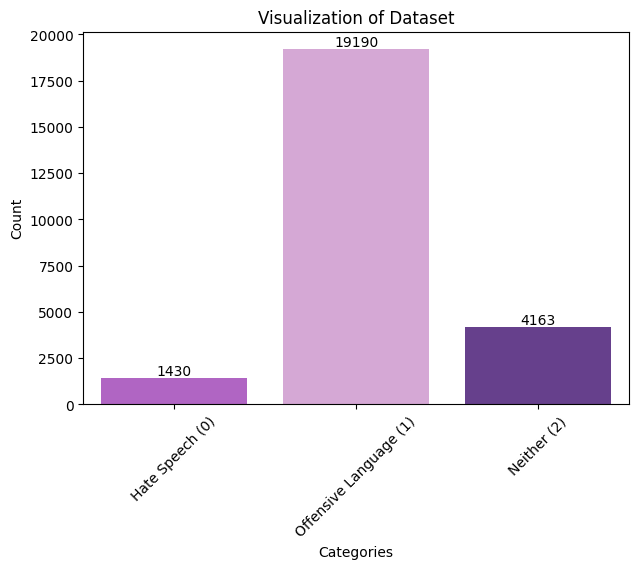

In [ ]:
# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['mediumorchid', 'plum', 'rebeccapurple']  # Purple shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')





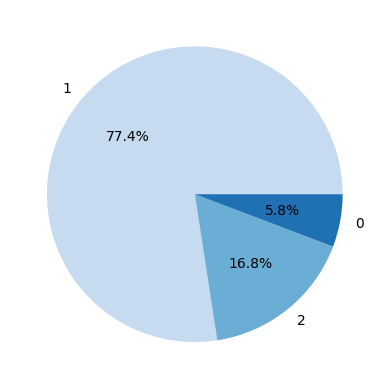

In [ ]:
blue_palette = sns.color_palette("Blues", n_colors=3)  # Customize 'n_colors' based on the number of slices

# Create a pie chart with the blue color palette
plt.pie(
    df['class'].value_counts().values,  # Values for the pie chart
    labels=df['class'].value_counts().index,  # Labels for each slice
    autopct='%1.1f%%',  # Display the percentage with one decimal place
    colors=blue_palette  # Set the color palette to shades of blue
)

# Display the pie chart
plt.show()

In [ ]:
y = df['class']
x = df.tweet

 **Balanced dataset using oversampling**

In [ ]:
#create two different dataframe of majority and minority class
df_class_1 = df1[(df1['class']==1)]
df_class_2 = df1[(df1['class']==2)]
df_class_0 = df1[(df1['class']==0)]
# undersample class_1 class
df_class_2_oversampled = resample(df_class_2,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# undersample class_1 class
df_class_0_oversampled = resample(df_class_0,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
oversampled_df  = pd.concat([df_class_2_oversampled, df_class_0_oversampled,df_class_1])

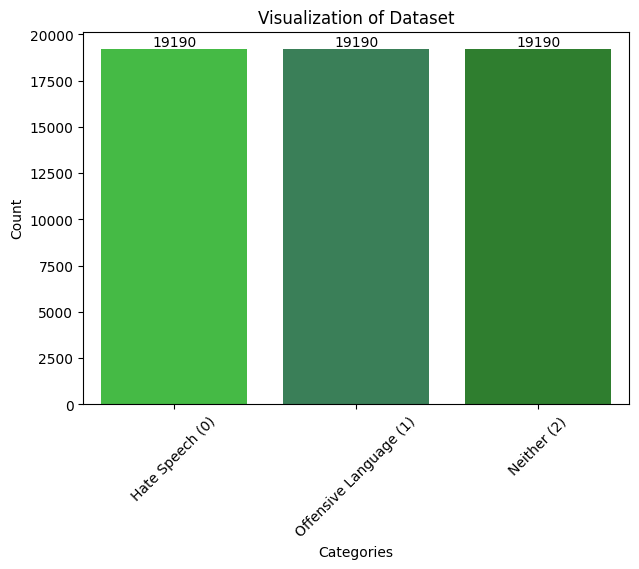

In [ ]:

# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = oversampled_df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['limegreen', 'seagreen', 'forestgreen']  # green shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')

In [ ]:
oversampled_df

,class,tweet
5073,2,nope super chocolatey yummy brownies
22172,2,thou shall not mock ryanthe futurekelly
18219,2,rt my trash is worth more than you
2869,2,penske runs the 22 in nascar its yellow ther...
20198,2,rt a birds eye view of todays activities t...
...,...,...
24774,1,you really care bout dis bitch my dick all in ...
24775,1,you worried bout other bitches you need me for
24778,1,yous a muthafin lie right his tl is tra...
24780,1,young buck wanna eat dat nigguh like i aint fu...


**Training word2Vec model**

In [ ]:
# Define the vocabulary size and the number of words in a sequence.
vocab_size = 50000
sequence_length = 35

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:


# Assuming oversampled_df is a Pandas DataFrame with a 'tweet' column
tweets = oversampled_df['tweet'].values

# Step 1: Convert the 'tweet' column to a TensorFlow Dataset
text_ds = tf.data.Dataset.from_tensor_slices(tweets)

# Step 2: Filter out any empty tweets
text_ds = text_ds.filter(lambda x: tf.cast(tf.strings.length(x), bool))

# Step 3: Batch the dataset and adapt the vectorize_layer
vectorize_layer.adapt(text_ds.batch(1024))


In [ ]:
text_ds

<_FilterDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'a', 'the', 'rt', 'i', 'you', 'to', 'bitch', 'and', 'is', 'in', 'that', 'of', 'my', 'like', 'on', 'me', 'be', 'trash']


In [ ]:

# Import AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

# Vectorize the data in text_ds
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()


In [ ]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

57570


In [ ]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [ ]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=42)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 57570/57570 [02:53<00:00, 332.24it/s]




targets.shape: (467994,)
contexts.shape: (467994, 5)
labels.shape: (467994, 5)


In [ ]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [ ]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)


<_PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [ ]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [ ]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [ ]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 67s 142ms/step - accuracy: 0.4492 - loss: 1.5676
Epoch 2/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 66s 143ms/step - accuracy: 0.6052 - loss: 1.2516
Epoch 3/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 85s 150ms/step - accuracy: 0.7509 - loss: 0.8975
Epoch 4/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 64s 141ms/step - accuracy: 0.8235 - loss: 0.6514
Epoch 5/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 81s 139ms/step - accuracy: 0.8632 - loss: 0.4979
Epoch 6/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 82s 140ms/step - accuracy: 0.8892 - loss: 0.3993
Epoch 7/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 82s 140ms/step - accuracy: 0.9083 - loss: 0.3319
Epoch 8/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 81s 139ms/step - accuracy: 0.9225 - loss: 0.2833
Epoch 9/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 64s 140ms/step - accuracy: 0.9330 - loss: 0.2466
Epoch 10/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 82s 139ms/step - accuracy: 0.9414 - loss: 0.2181
Epoch 11/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 64s 141ms/step - accuracy: 0.9477 - loss: 0.1954
Epoch 12/20
457/457

**Data Spliting**

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(oversampled_df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 20654 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(oversampled_df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (57570, 250)


In [ ]:
Y = pd.get_dummies(oversampled_df['class']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (57570, 3)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

**Creating RNN model**

In [ ]:
# Get the embedding matrix from the target_embedding layer
embedding_matrix = word2vec.target_embedding.get_weights()[0]

# vocab_size and embedding_dim are derived from the embedding matrix shape
vocab_size = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]
model = Sequential()

# Load the pre-trained word2vec embeddings into the Embedding layer
# Note that we set trainable=False to avoid modifying the pre-trained weights
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=X.shape[1],
                    trainable=False))

model.add(SpatialDropout1D(0.1))
model.add(SimpleRNN(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define EarlyStopping with a desired metric and patience level
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Stop after 3 epochs with no improvement
    restore_best_weights=True,  # Restore the best model weights
    mode='min'  # 'min' to minimize the monitored metric (loss)
)


In [ ]:
model.compile(optimizer='adam',
                   loss='categorical_crossentropy',  # Adjust based on your task
                   metrics=['accuracy'])

In [ ]:
epochs = 10
batch_size = 64

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[early_stopping])
accr =model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 82s 137ms/step - accuracy: 0.4700 - loss: 1.0342 - val_accuracy: 0.5908 - val_loss: 0.8796
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 104s 175ms/step - accuracy: 0.5648 - loss: 0.9274 - val_accuracy: 0.5968 - val_loss: 0.8738
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 165s 215ms/step - accuracy: 0.5864 - loss: 0.8858 - val_accuracy: 0.6340 - val_loss: 0.8239
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 97s 136ms/step - accuracy: 0.6041 - loss: 0.8664 - val_accuracy: 0.5620 - val_loss: 0.9151
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 82s 136ms/step - accuracy: 0.5819 - loss: 0.8989 - val_accuracy: 0.6360 - val_loss: 0.8282
Epoch 6/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 84s 140ms/step - accuracy: 0.6170 - loss: 0.8541 - val_accuracy: 0.6556 - val_loss: 0.7944
Epoch 7/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 79s 136ms/step - accuracy: 0.6376 - loss: 0.8268 - val_accuracy: 0.6938 - val_loss: 0.7379
Epoch 8/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 83s 138ms/step - accuracy: 0.6640 - loss:

In [ ]:
y_pred =model.predict(x_test)

540/540 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step


**Validation**

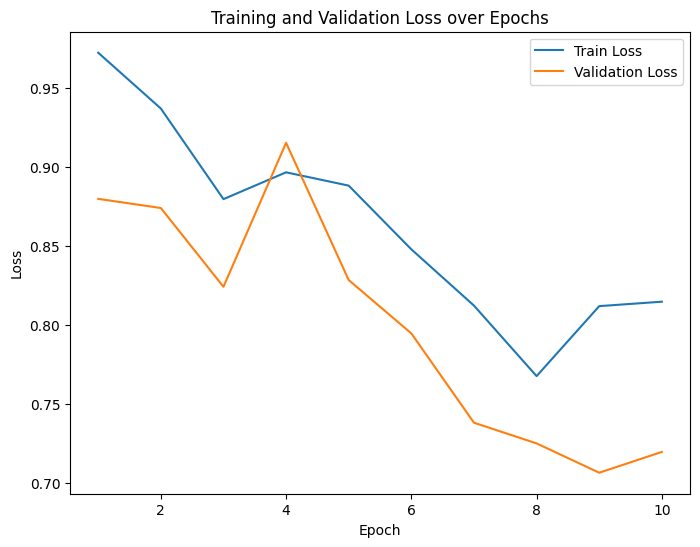

In [ ]:
epochs = list(range(1, len(history.history['loss']) + 1))  # Create a list of epochs


# Combine training and validation loss into a DataFrame
Simple_RNN_df = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss'],
})

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=Simple_RNN_df, x='Epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=Simple_RNN_df, x='Epoch', y='Validation Loss', label='Validation Loss')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

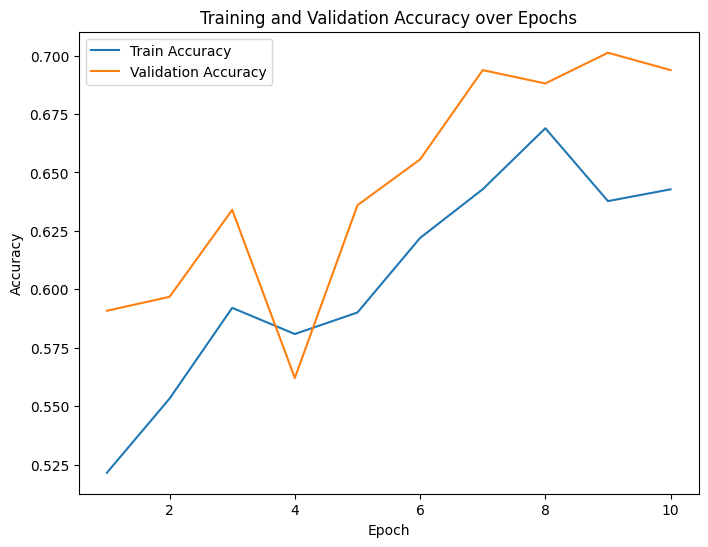

In [ ]:
epochs = list(range(1, len(history.history['accuracy']) + 1))

# Create a DataFrame for training and validation accuracy
accuracy_df = pd.DataFrame({
    'Epoch': epochs,
    'Train Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy'],
})

# Plot the training and validation accuracy with Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=accuracy_df, x='Epoch', y='Train Accuracy', label='Train Accuracy')
sns.lineplot(data=accuracy_df, x='Epoch', y='Validation Accuracy', label='Validation Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<Axes: >

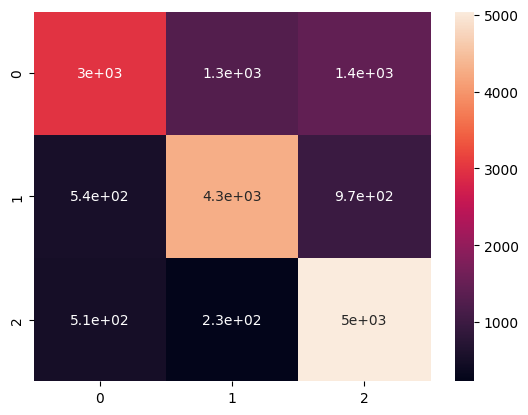

In [ ]:
cm_RNN= confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))
sns.heatmap(data=cm_RNN, annot=True)

In [ ]:
print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1),labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.74      0.52      0.61      5693
           1       0.74      0.74      0.74      5798
           2       0.68      0.87      0.76      5780

    accuracy                           0.71     17271
   macro avg       0.72      0.71      0.70     17271
weighted avg       0.72      0.71      0.71     17271



In [ ]:
np.argmax(y_test,axis=1)
# Calculate accuracy, F1-score, recall, and precision
accuracy = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))  # Calculate accuracy
f1 = f1_score(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1), average='macro')  # Calculate F1-score using macro average
recall = recall_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1), average='macro')  # Calculate recall using macro average
precision = precision_score(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1), average='macro')  # Calculate precision using macro average

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.7124080829135545
F1 Score: 0.7047885643154107
Recall: 0.7114366101343726
Precision: 0.7185429154793205


In [ ]:
new_array = [["you bitch"],["your're very good"],["you damn girl"]]
lables =['hate speech','offensive language','neither']

In [ ]:
for message in new_array:
  X = tokenizer.texts_to_sequences(message)
  X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  output= model.predict(X)
  print(output,lables[np.argmax(output)],message,"\n")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[0.17442442 0.8179369  0.00763868]] offensive language ['you bitch'] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.09640115 0.13102122 0.77257764]] neither ["your're very good"] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.15359543 0.3211978  0.5252068 ]] neither ['you damn girl'] 

